In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
from sklearn.metrics import confusion_matrix
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [4]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

In [5]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [6]:
clinton_model = bmb.Model("vote['clinton'] ~ age", clinton_data, family="bernoulli")

In [7]:
clinton_fitted = clinton_model.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Modeling the probability that vote==clinton


Compiling...


Compilation time =  0:00:01.211638
Sampling...


  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                                           | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                                           | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                                           | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                                           | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1344.49it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1345.59it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1346.63it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1347.64it/s]

Sampling time =  0:00:01.761461
Transforming variables...
Transformation time =  0:00:00.003800
Computing Log Likelihood...


Log Likelihood time =  0:00:00.377440


In [8]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, age]


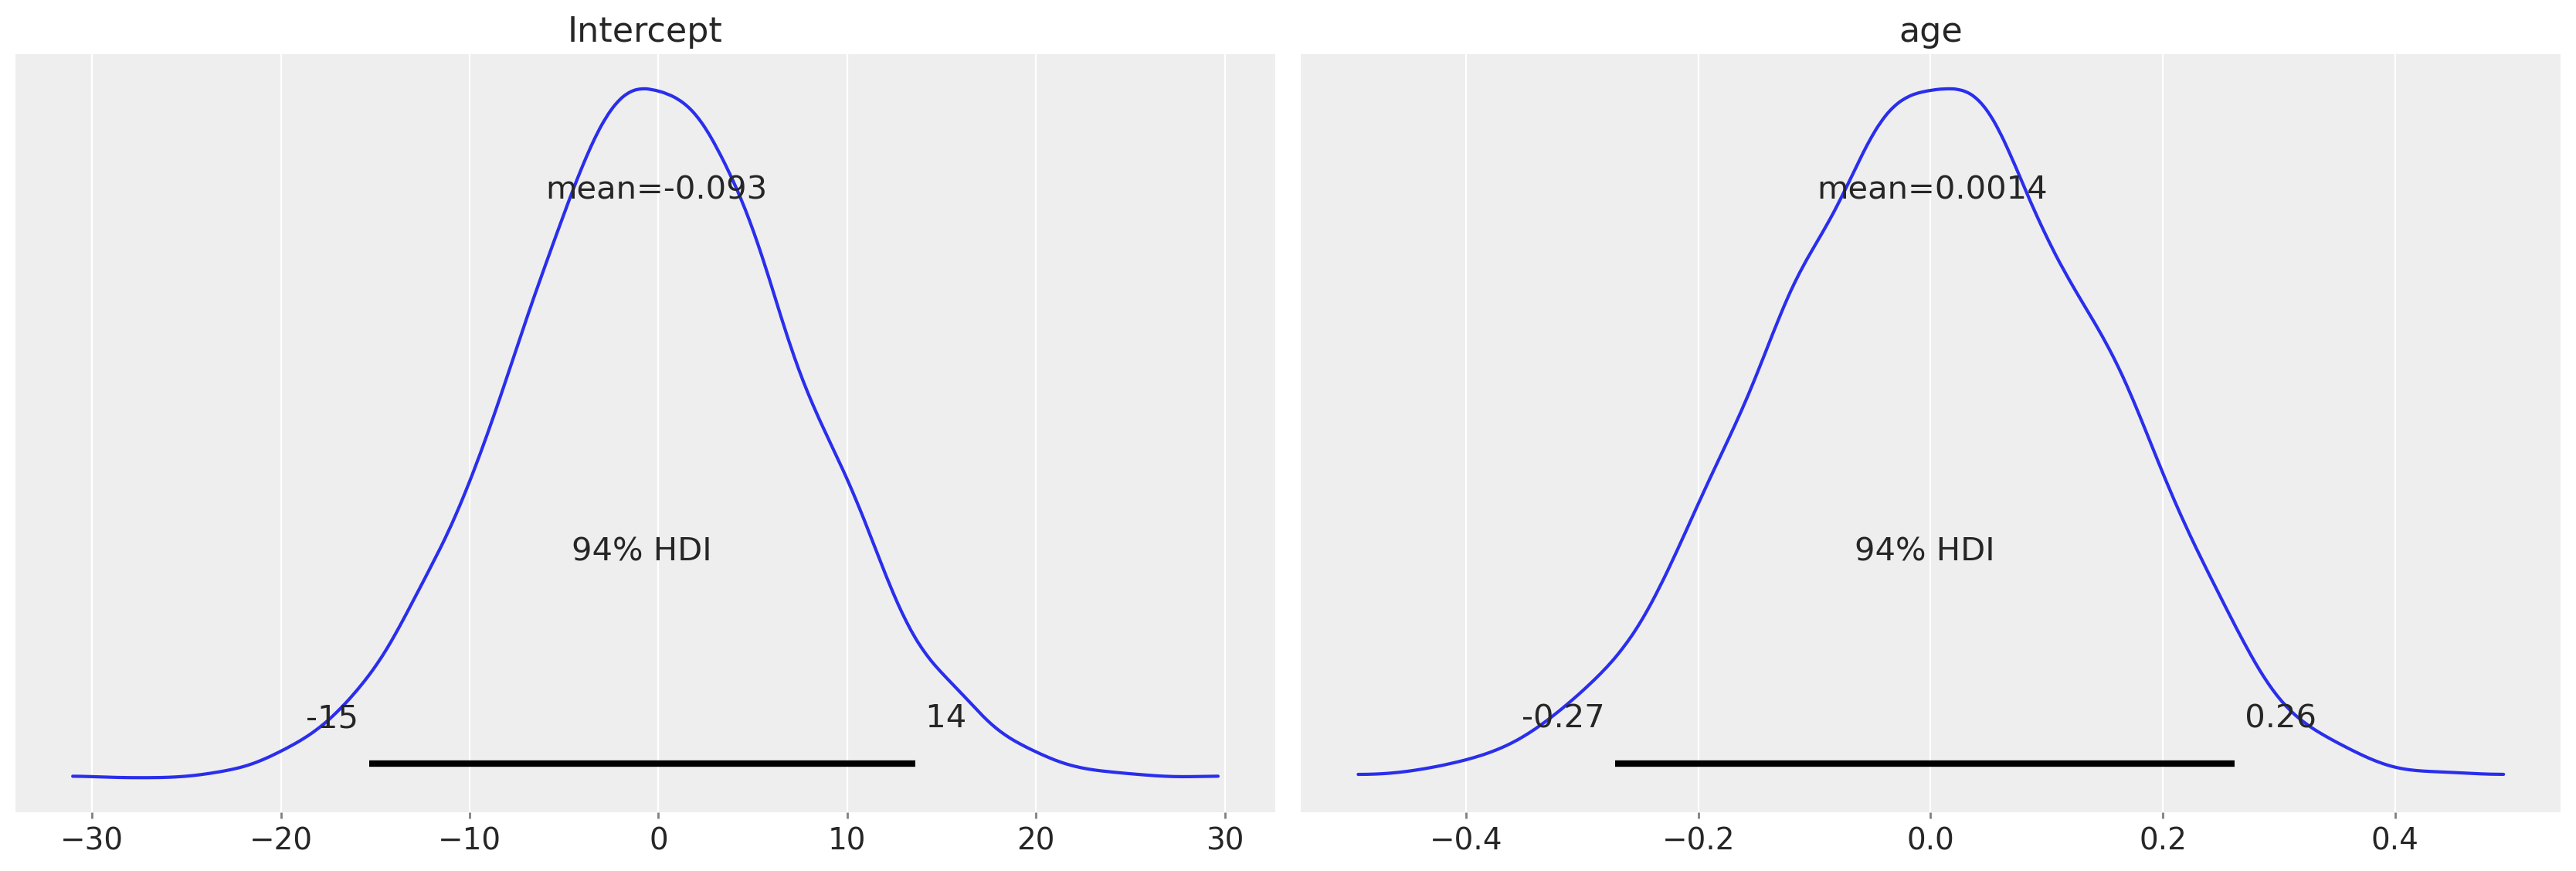

In [9]:
clinton_model.plot_priors()
plt.show()

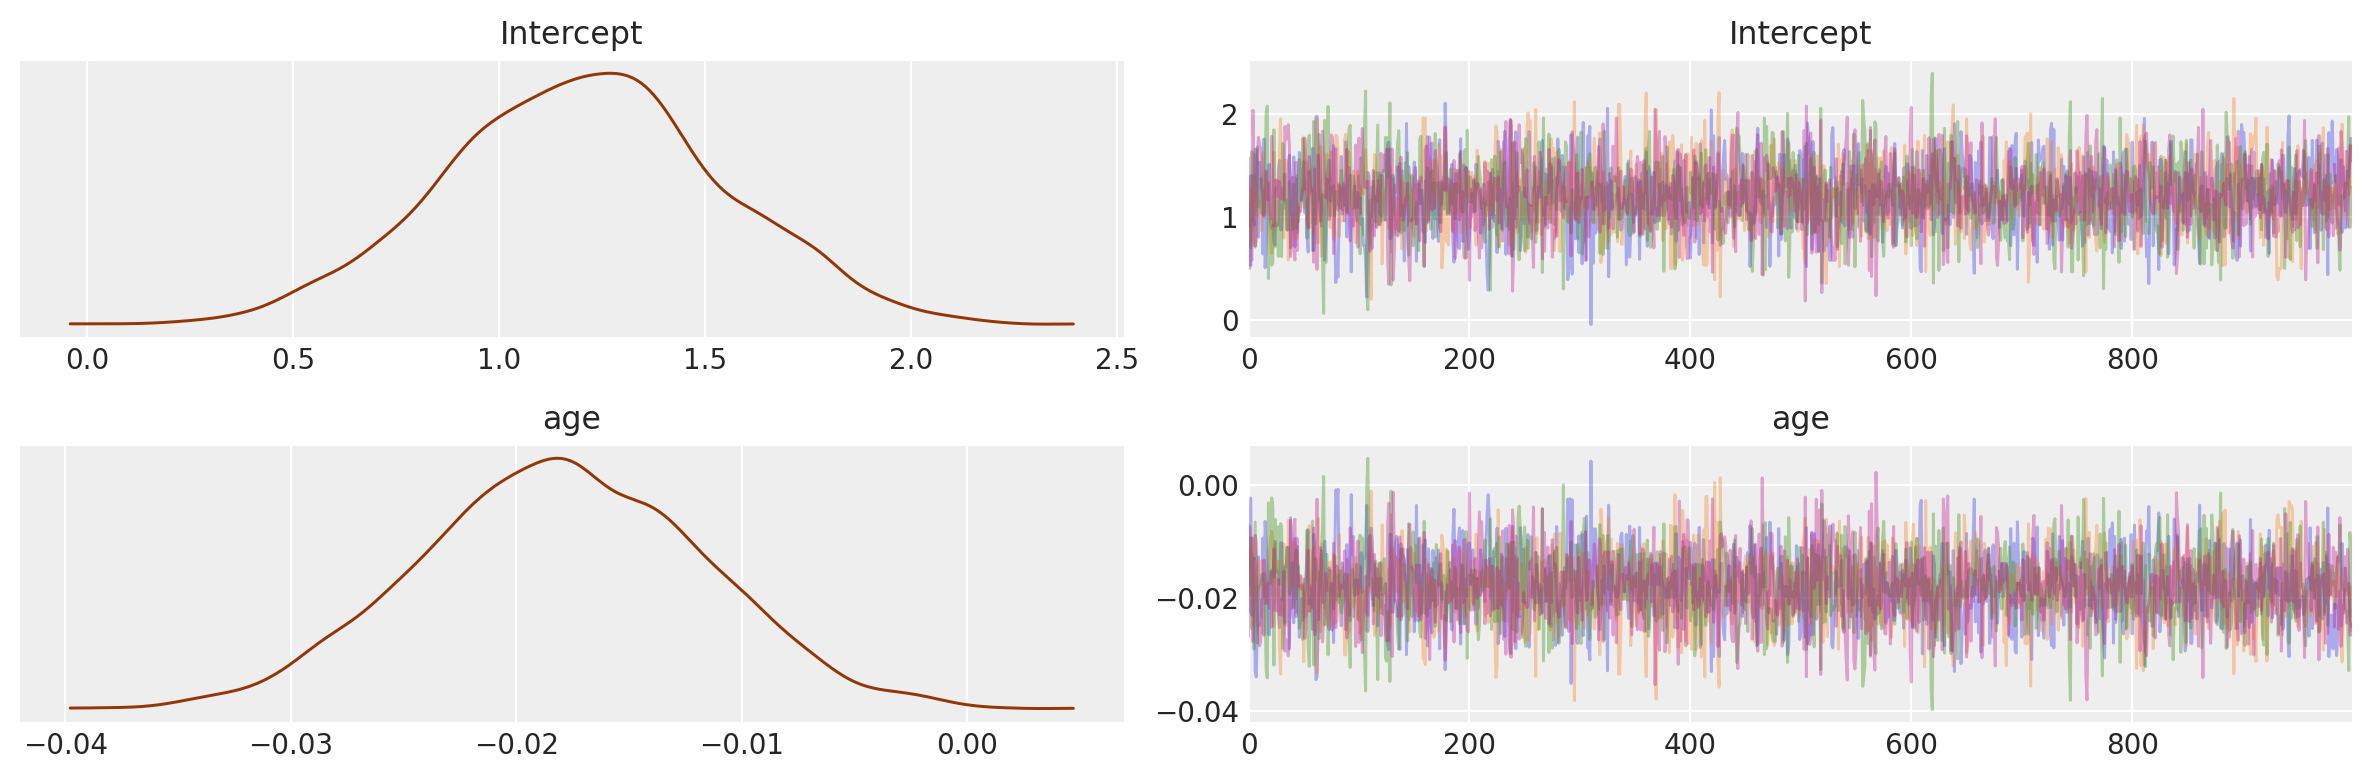

In [10]:
az.plot_trace(clinton_fitted, combined=True, compact=False)
plt.tight_layout()
plt.show()

In [11]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

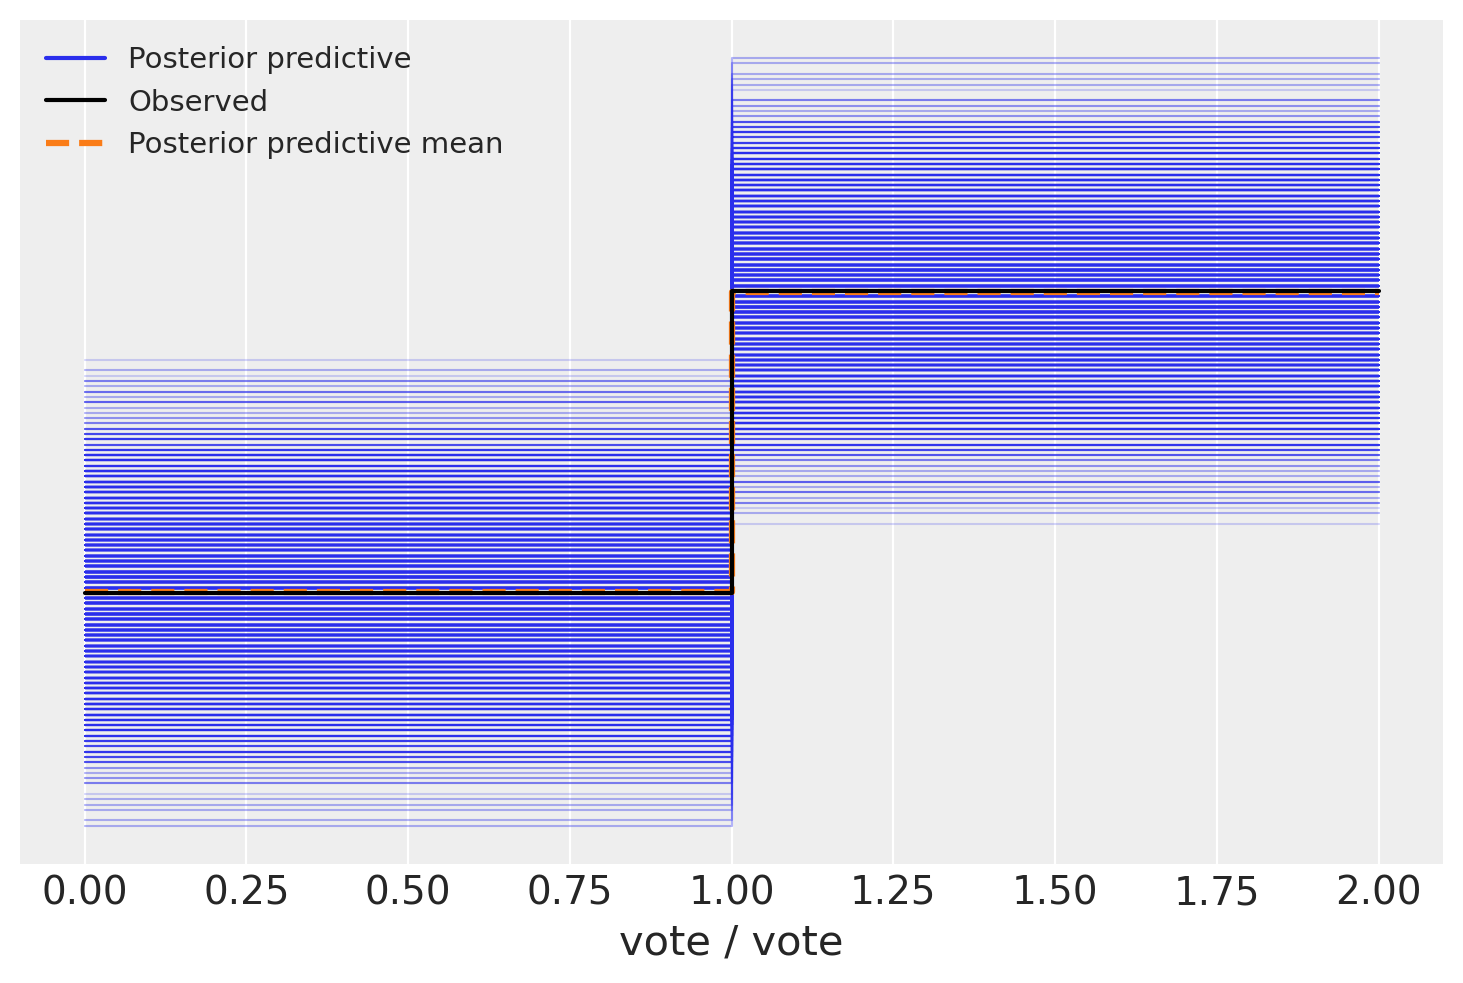

In [12]:
az.plot_ppc(clinton_fitted)
plt.show()

In [13]:
loo = az.loo(clinton_fitted, pointwise=True)

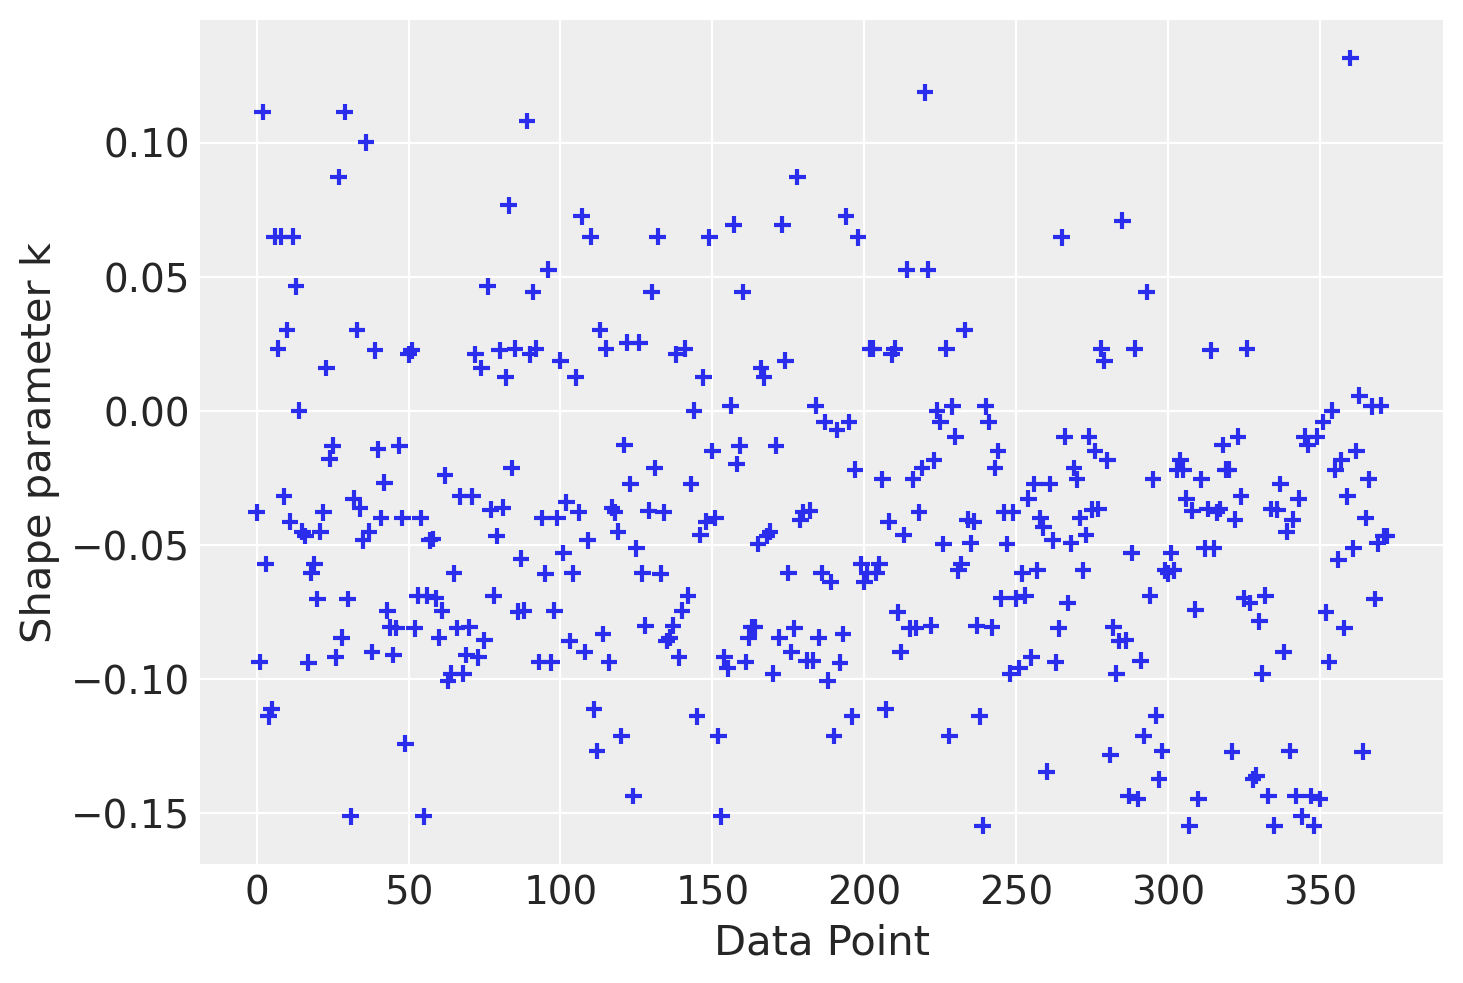

In [14]:
az.plot_khat(loo.pareto_k)
plt.show()

In [15]:
summary_df = az.summary(clinton_fitted)
print(summary_df)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       1.206  0.337   0.579    1.840      0.006    0.004    3735.0   
age            -0.018  0.006  -0.029   -0.006      0.000    0.000    3907.0   
vote_mean[0]    0.549  0.028   0.495    0.601      0.001    0.000    3124.0   
vote_mean[1]    0.508  0.036   0.444    0.577      0.001    0.000    3430.0   
vote_mean[2]    0.442  0.053   0.344    0.542      0.001    0.001    3744.0   
...               ...    ...     ...      ...        ...      ...       ...   
vote_mean[368]  0.606  0.028   0.553    0.658      0.001    0.000    3140.0   
vote_mean[369]  0.593  0.027   0.544    0.646      0.000    0.000    3075.0   
vote_mean[370]  0.513  0.035   0.451    0.580      0.001    0.000    3393.0   
vote_mean[371]  0.622  0.030   0.568    0.682      0.001    0.000    3246.0   
vote_mean[372]  0.622  0.030   0.568    0.682      0.001    0.000    3246.0   

                ess_tail  r_hat  
Intercept        

In [16]:
beta_0 = summary_df.loc['Intercept', 'mean']
print(beta_0)

1.206


In [17]:
np.exp(beta_0)

3.3400975060812867

In [18]:
np.exp(beta_0) / (1 + np.exp(beta_0))

0.7695904300309351

In [19]:
beta_1 = summary_df.loc['age', 'mean']
print(beta_1)

-0.018


In [20]:
np.exp(beta_1)

0.9821610323583008

In [21]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [22]:
clinton_model.predict(clinton_fitted, data=new_data)

In [23]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

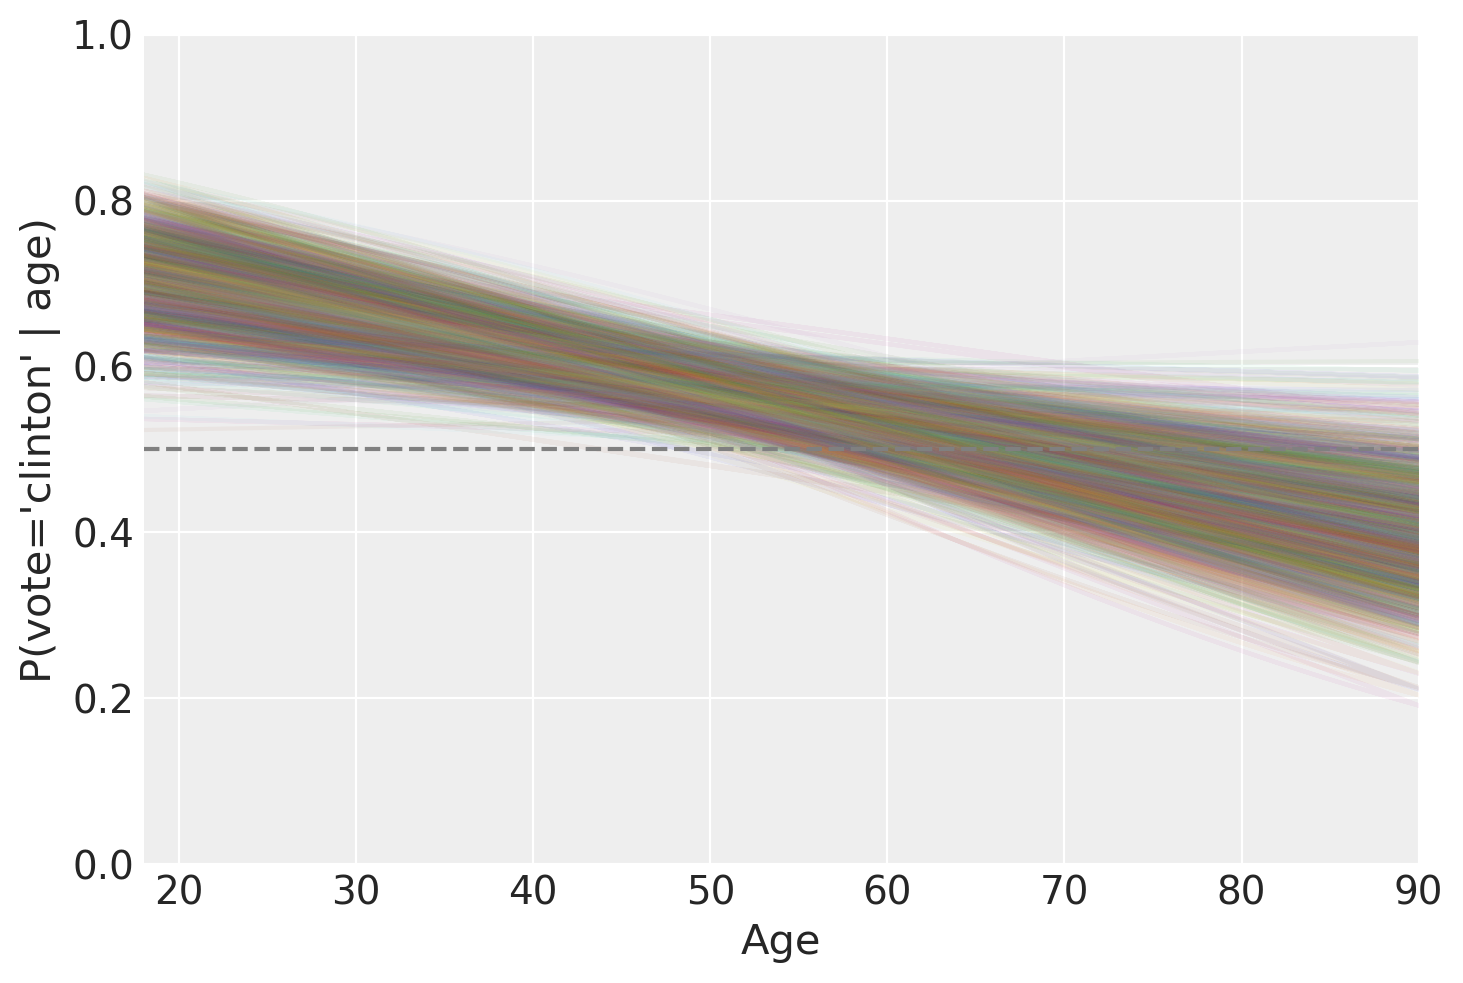

In [24]:
plt.plot(new_data.age, vote_posterior, alpha=0.05)

# Adding a dashed horizontal line at y=0.5 (50% probability)
plt.axhline(y=0.5, color="gray", linestyle="dashed")

plt.ylabel("P(vote='clinton' | age)")
plt.xlabel("Age")
plt.ylim(0, 1)
plt.xlim(18, 90);

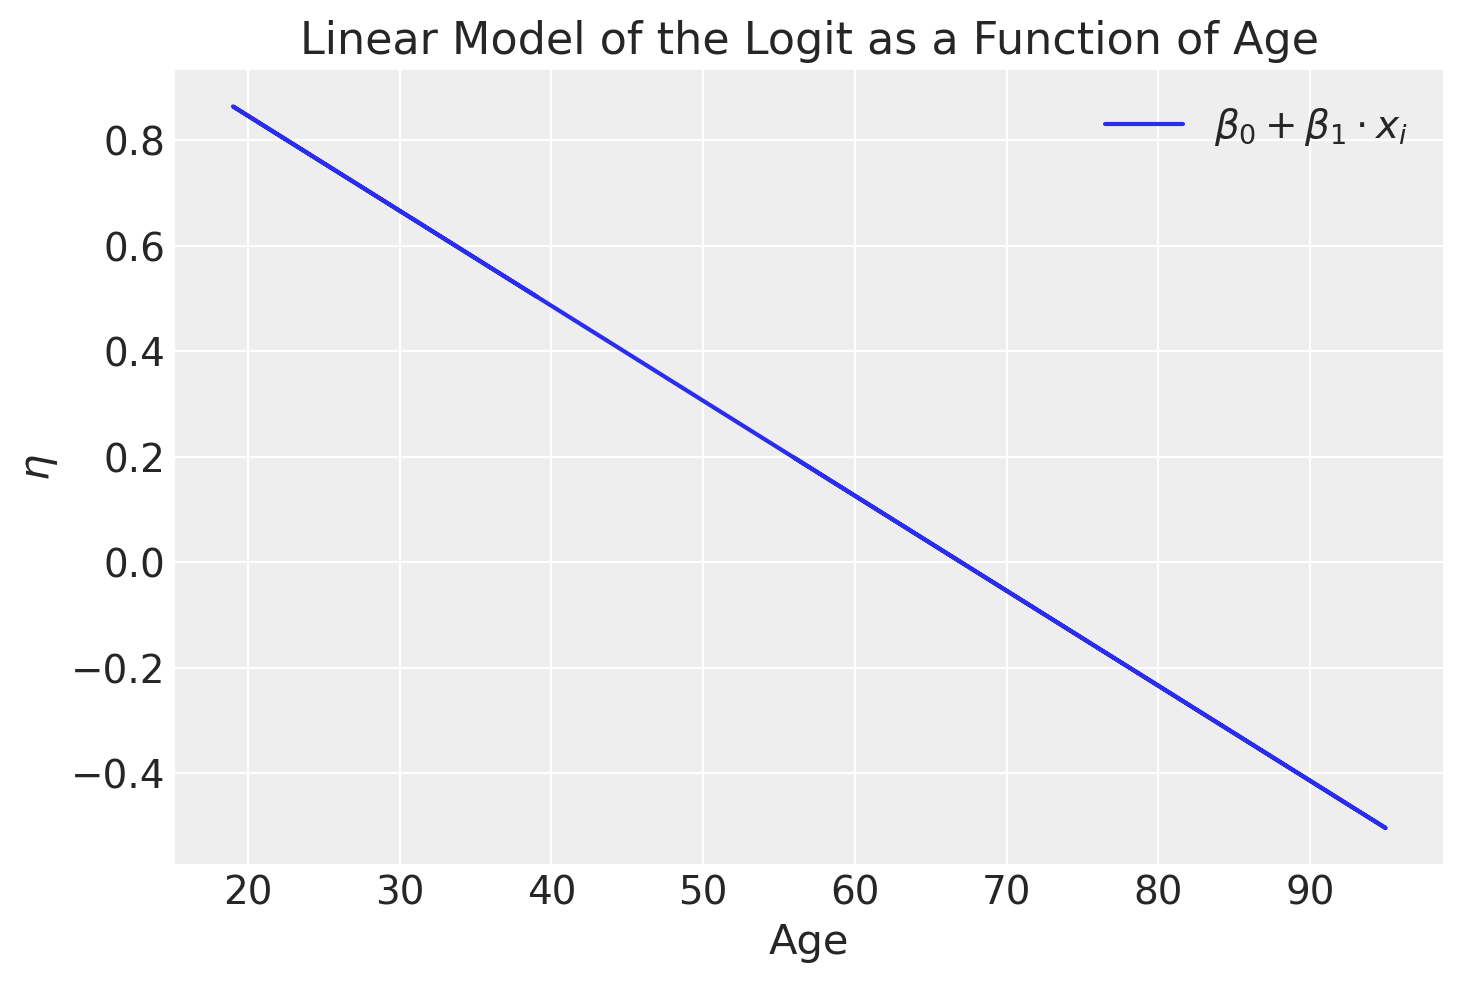

In [25]:
eta = beta_0 + beta_1 * clinton_data["age"]

plt.figure()
plt.plot(clinton_data["age"], eta, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("Age")  # Label for the x-axis
plt.ylabel(r"$\eta$")  # Label for the y-axis
plt.title("Linear Model of the Logit as a Function of Age")  # Title for the plot
plt.legend()
plt.show()

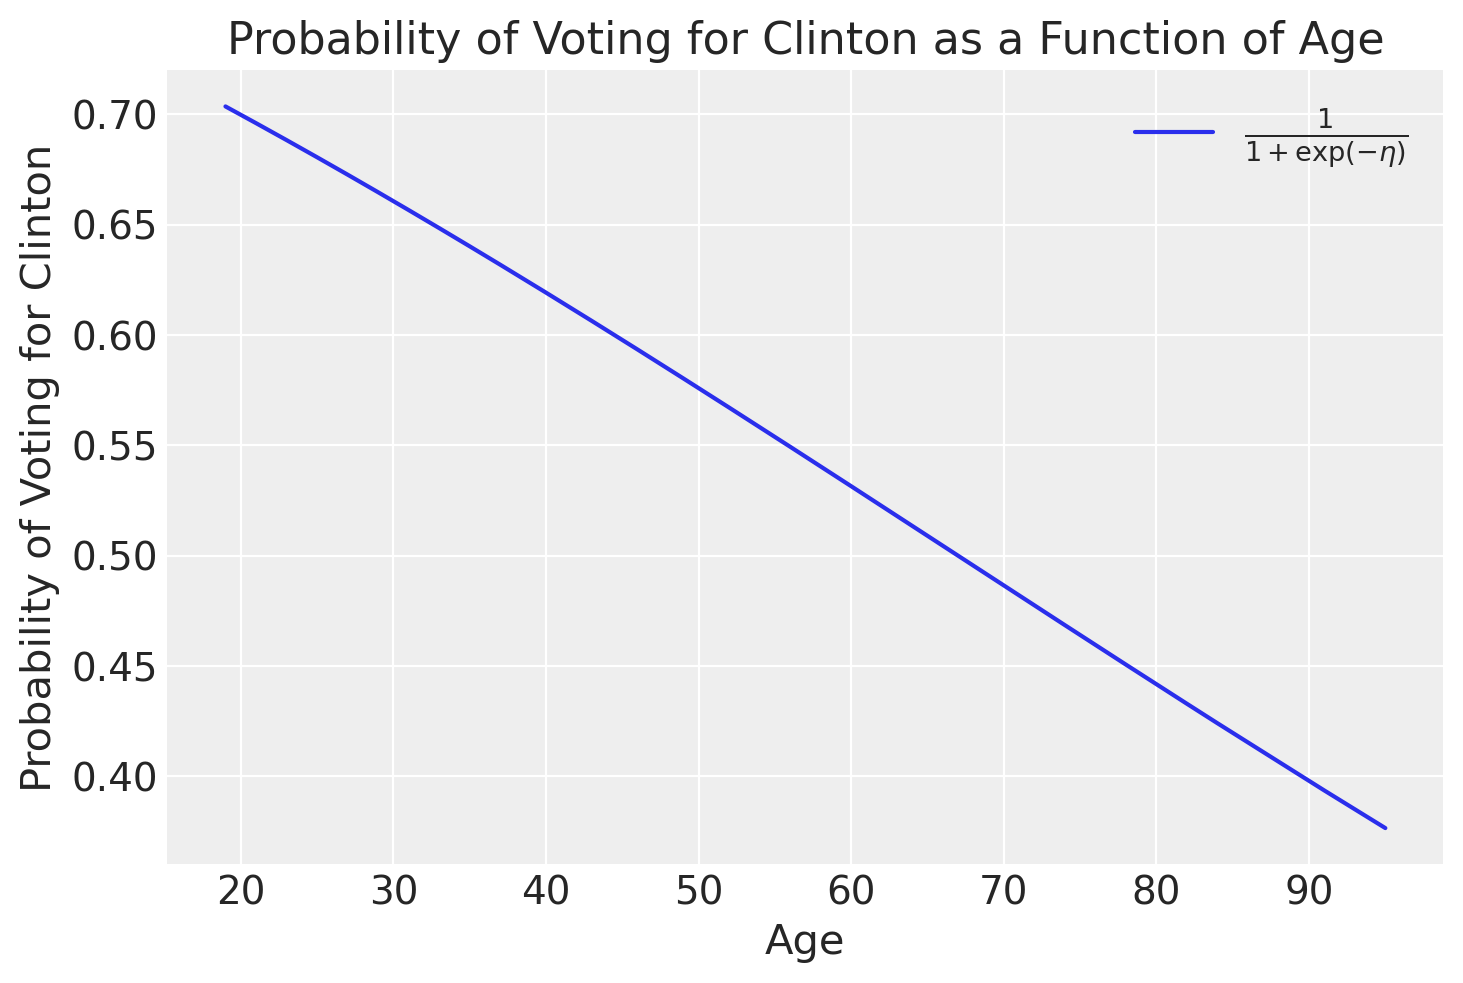

In [26]:
# Sort the age data first
sorted_age = np.sort(clinton_data["age"])

# Calculate eta using the sorted ages
eta_sorted = beta_0 + beta_1 * sorted_age

# Compute the sigmoid function
p_true_sorted = 1 / (1 + np.exp(-eta_sorted))

# Now, plot the sigmoid curve
plt.figure()
plt.plot(sorted_age, p_true_sorted, label=r"$\frac{1}{1 + \exp(-\eta)}$")
plt.xlabel("Age")
plt.ylabel(r"Probability of Voting for Clinton")  
plt.title("Probability of Voting for Clinton as a Function of Age")
plt.legend()
plt.show()

In [27]:
clinton_model.predict(clinton_fitted)

In [28]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.53386131, 0.48315942, 0.39992229, ..., 0.48879495,
         0.62695463, 0.62695463],
        [0.55319686, 0.52563838, 0.47944235, ..., 0.52871127,
         0.60424213, 0.60424213],
        [0.59918042, 0.59421386, 0.58589372, ..., 0.59476667,
         0.6085056 , 0.6085056 ],
        ...,
        [0.55978021, 0.50735167, 0.42018191, ..., 0.51320639,
         0.65442869, 0.65442869],
        [0.59966745, 0.5461998 , 0.45530499, ..., 0.55221731,
         0.69365813, 0.69365813],
        [0.58606544, 0.53037115, 0.43654869, ..., 0.53662314,
         0.68455421, 0.68455421]],

       [[0.58592351, 0.54503213, 0.47578986, ..., 0.54961623,
         0.65963709, 0.65963709],
        [0.56733999, 0.54198619, 0.49930808, ..., 0.54481651,
         0.61418304, 0.61418304],
        [0.54486614, 0.50138951, 0.42920564, ..., 0.50623337,
         0.62465477, 0.62465477],
...
        [0.60491843, 0.58664909, 0.55568742, ...

In [29]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

,vote,age,party_id,probs
0,clinton,56,democrat,0.548535
1,trump,65,republican,0.508210
2,clinton,80,democrat,0.441549
3,trump,38,republican,0.626655
4,trump,60,republican,0.530647


In [30]:
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);

In [31]:
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

In [32]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 33 125]
 [ 31 184]]


In [33]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

In [34]:
184/ (31+184)

0.8558139534883721

In [35]:
33 / (33+125)

0.2088607594936709

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 24 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

arviz     : 0.16.1
pandas    : 2.1.1
numpy     : 1.25.2
bambi     : 0.12.0
matplotlib: 3.8.0
seaborn   : 0.12.2

Watermark: 2.4.3

